# SCS 3546 Deep Learning 

# Module 08: Representational Learning and Variational Methods
***


## Learning Outcomes

By the end of this module:

- Learners will have a comprehensive understanding of representational learning, generative models, and their applications. 
- Learners will know when and how to train and use (Variational) Autoencoders and,
  - are poised to follow and comprehend new advances in these domains; 
  - have the foundational knowledge necessary to understand Fully Visible Belief Nets (FVBN) and Generative Adversarial Networks (GAN) that are introduced in the following module.
 
## Topics
- Autoencoders
  - Theory and Background
  - Hands on Demo
  - Applications: Denoising, Compression, Feature Selection, Image Segmentation, ..

- Intro to Generative Models
  - Sample generation by fitting a Gaussian
  - Taxonomy of Generative Models
- Variational Autoencoders
  - Theory
  - *[Optional]* Mathematical background
  - Hands on Demo


# Setup

In [ ]:

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Part 1: Representational Learning 
***

Representational Learning refers to techniques that allow machine learning models to automatically learn **efficient** and **robust** representations of data (i.e. good features). Many such techniques use the concepts of an "encoder" and "decoder". An "encoder" transforms the raw data inputs into a lower-dimensional representation, which we call a 'latent vector'. A "decoder" maps that latent vector back into the source data domain. 

We have seen the power of using encoders in previous modules. For example, in transfer learning, we treated the first layers of a pre-trained model as an encoder, and then added our own layers on top of it to adapt the network to a new prediction task. This allowed us to take a model such as VGG-16, which was trained on millions of images, and re-use its feature representations to help us accurately classify flower images, even though we had fewer than 200 images from which to learn 5 different classes of flowers. We have also seen encoders in the form of word embeddings, for example when we used BERT to convert words to vectors that captured their semantic meaning (i.e. "King - Man + Woman = Queen").  

Decoders have also been used a few times so far in this course. In the RNN module, we discussed the example of an encoder-decoder language translation model, which would first map the input sentence (e.g. English) to a vector, and then pass that vector onto a decoder that maps it to the target language (e.g. German). We also saw an example in Module 04 with Convolution-Deconvolution Networks for image semantic segmentation, in which the model must classify semantic regions on the latent vector, and map these classifications back to the individual input pixels. 

Encoder-decoder networks have additional uses beyond these. For example, what if we have lots of data, but very little of that data is labelled? In that case, supervised training with target labels isn't immediately possible. But we can nonetheless learn useful features from that data using an architecture called an **autoencoder**. What's more, we can also help our network learn features that are robust against noise, so that small imperfections in the input, such as blurs or digital artifacts on an image, don't throw off our classification tasks. 

We will explore **autoencoders** and their applications in the next section. 



## Autoencoders

Autoencoders are an unsupervised learning technique where the goal is to compress the input down to a lower dimensionality, and then reconstruct the input at the output. They can be made from any of the network types we have seen before (dense layers, convolutional layers, etcetera). By compressing a high dimensional input into a smaller dimensional representation using a *bottleneck*, and then reconstructing the input, they can learn useful features for modelling the data, even though there are no data labels. 


<center><img src="https://drive.google.com/uc?id=1RWdaWrtKcMkZZ84f-pBK56P9aNDBSq2h" ></center>


In the above picture we see the high dimensional input (which is an image in this case) is passed through a fully connected layer, and in the middle a lower dimensional representation of the input is constructed. Later the reverse process is applied to reconstruct the given image. The first segment of the network is called an *Encoder* and the second segment is called a *Decoder*. The space of the compressed representations is sometimes called the *latent* or *feature space*. Note that the encoder and the decoder networks can be fully connected, convolutional or any other type of a network.

The loss function for this task is simply the reconstruction error: $||x-x'||^2$, which measures the differences between the original input and the generated output.

The question is why do we want to compress the information about the input in a lower dimensional space at all? The answer is that by doing this, we are encapsulating the most important features of X in that lower dimensional vector. This is exactly the reason why we do *Principal Components Analysis (PCA)*. In fact if we get rid of the activation functions in the above network and only use linear units, we get the same effect as PCAs (Check out Geoffrey Hinton's __[video](https://www.youtube.com/watch?v=hbU7nbVDzGE)__ regarding this).

<div class="alert alert-block alert-warning">
<b>Note:</b> For dimensionality reduction, contrary to PCA that discovers a lower dimensional hyperplane to describe the data, the Autoencoders, with their non-linear activation functions, can capture more generalized non-linear *manifolds*. So in that regard the Autoencoders are more powerful than PCA's. The following image shows this difference:


<figure>
    <center><img src="https://drive.google.com/uc?id=1bdErwFvmlRGxytuZ9nGTgfb1-T-4WuV7" width="400"></center>
    <figcaption>
        <center>Jordan, J. (2018, March). Introduction to Autoencoders. </center><center>Retrieved from https://www.jeremyjordan.me/autoencoders/</center></figcaption>
</figure>

</div>

### Unsupervised Pretraining Using Stacked Autoencoders

After training the whole network, we can get rid of the decoder and use the feature vector that comes out of the encoder for other classification tasks:

<center><img src="https://drive.google.com/uc?id=1aaez9BQJanpIAfYf6EiTkLHqW-dRvOLs" ></center>

This is a common practice when our training set is small. So we can spend some time training the Autoencoder in order to initialize our classification task with the hope that the encoder then can capture the most important features of the data distribution and can aid the classifier.



### Autoencoders: Demo

So now that we know the theory and intuition behind Autoencoders, let's write our own with TensorFlow. We'll use the MNIST dataset to see what happens when we compress each digit image into a low-dimensional vector, and then attempt to reconstruct that image from the vector. 

In the animation below, we plot some examples of reconstructed images after subsequent mini-batches. For each, we plot the original image, its encoded vector representation (in this case, a latent vector of dimensionality 3), and it's reconstruction. You can see that after enough iterations of training this auto-encoder, for most classes we can do a pretty decent job of reconstructing an image. That's pretty astounding, considering we've gone from 784 dimensions to three. It's not perfect however, so we could try again with a larger latent vector dimensionality (e.g. 6 or 12 elements). The goal would be to find the smallest dimensionality that still preserves most of the relevant information about the input. 


<center><img src="https://drive.google.com/uc?id=129LFTHFG8d0zzogGd8K7_cHwK908kjVu" >
</center>

Below, we implement an autoencoder for Fashion-MNIST from scratch. You can set the `latent_size` to change the dimensionality (number of neurons) of the latent space and see it's effect on the accuracy of the reconstructed images.

For additional examples of autoencoders, check out this link: https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb


In [ ]:
# load and normalize MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
# set random seeds to aid reproducibility
tf.random.set_seed(42)
np.random.seed(42)

latent_size = 30 # defines the dimensionality of the bottleneck

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# define our encoder
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(latent_size, activation="selu"),
])

# define our decoder
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[latent_size]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

# compile and train the model
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.01), 
    metrics=[rounded_accuracy]
)

# Note, in this case, the targets are the same as the input! That's why we've
# passed X_train for the 'y_train' parameter. 
history = stacked_ae.fit(
    X_train, 
    X_train, 
    epochs=20,
    validation_data=(X_valid, X_valid)
)

Epoch 1/20
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3033 - rounded_accuracy: 0.9148 - val_loss: 0.2979 - val_rounded_accuracy: 0.9188
Epoch 2/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2933 - rounded_accuracy: 0.9226 - val_loss: 0.2931 - val_rounded_accuracy: 0.9234
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2915 - rounded_accuracy: 0.9241 - val_loss: 0.2918 - val_rounded_accuracy: 0.9245
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2910 - rounded_accuracy: 0.9244 - val_loss: 0.2947 - val_rounded_accuracy: 0.9209
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2907 - rounded_accuracy: 0.9247 - val_loss: 0.2924 - val_rounded_accuracy: 0.9264
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2902 - rounded_accuracy: 0.9250 - val_loss: 0.2952 - val_rounded_accuracy: 0.9210
Epoch 7/20
1719/1719 [================

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 97ms/step


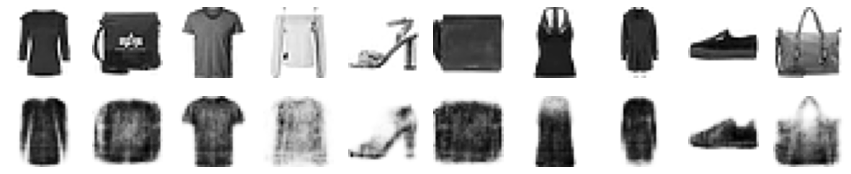

In [ ]:
show_reconstructions(stacked_ae)


Note, to keep things simple, the above exercise used dense layers, which we already know aren't the most efficiently layers to use for extracting spatial information. As an exercise, feel free to create your own auto-encoder, but using convolutional layers, instead of dense layers. See Module 04 for examples of how to perform de-convolutions. 

### Visualizing Fashion MNIST in our Latent Space

Now that we've compressed our Fashion MNIST images to lower dimensionality, let's look at the patterns of how each of our clothing classes are distributed in this lower-dimensional latent space. 

To visualize clustering in this space, we'll make use of the TSNE approach. 

In [ ]:
# the goal of TSNE is simply to allow us to visualize the distribution in our
# N-dimensional latent space in two dimensions, since our brains can't think in 
# terms of N dimensions where N > 3 (unless yours can, you alien!)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)

tsne = TSNE()

# produce a 2D visualization of clustering
X_valid_2D = tsne.fit_transform(X_valid_compressed) 

# renormalize the locations
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 1ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


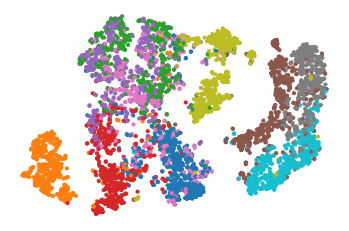

In [ ]:
# let's visualize the different clusters, as labelled by our target classes
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

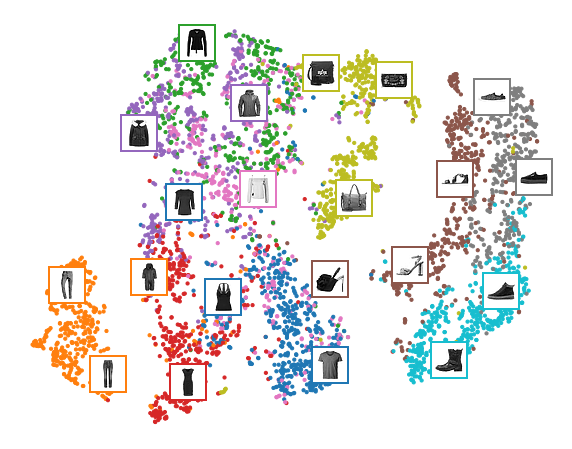

In [ ]:
# we can spread these clusters out a little more, and plot sample images
# representing an image located at that area of the latent space

# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

### Auto-Encoders for Data Compression
Since the encoded image is often much smaller than the original, the Autoencoders can be used very effectively in (Lossy) image compression. There has been a lot of research in using *Convolutional Autoencoders (CAE)* for image compression. The idea is to pass the image through a type of a convolutional encoder and get a compressed image. The compressed image can then be transferred over a communication network (e.g. the internet), and at the destination the decoder passes the image through deconvolutional layers to obtain the original image. 

We are all familiar with image compression through the JPEG file format. The ultimate goal with CAEs is to be able to compress image data far more efficiently than existing techniques by using learned features. 

The following figure compares state of the art autoencoder compression techniques against existing classical compresison methods (JPEG and JPEG2000), where bpp = bytes per pixel. The CAEs from 2018 in this figure aren't quite as good as JPEG2000, but they are getting closer every year. 

<p>
<figure>
    <center><img src="https://drive.google.com/uc?id=1cujhYy2DFlR_lo1WDm_0fZ57aPERUU4Y" ></center>
    <figcaption><center>Raw image (a) and reconstructed images (300 × 300) cropped from Kodak images using (b)JPEG, (c)JPEG2000 and (d)CAE.</center>
        <center>[<b>Image credit:</b> Cheng, Z., Sun, H., Takeuchi, M., & Katto, J. (2018). Deep Convolutional AutoEncoder-based Lossy Image Compression. 2018 Picture Coding Symposium (PCS).]</center></figcaption>
</figure>
<p>

### Exercise: Convolutional Autoencoders

When working with image datasets or similar problems, we know that convolutional layers are are better choice than dense layers. In the exercise below, try to build a convolutional autoencoder for the fashion MNIST dataset. 


In [ ]:
(X_train, y_train), (X_test, y_test) =  keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [ ]:
### your response here ...

In [ ]:
### your response here ...

In [ ]:
### your response here ...

In [ ]:
### your response here ...

In [ ]:
### your response here ...

#### Solution

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[rounded_accuracy]
)
history = conv_ae.fit(
    X_train, 
    X_train, 
    epochs=5,
    validation_data=(X_valid, X_valid)
)

Epoch 1/5
1875/1875 [==============================] - 11s 5ms/step - loss: 0.3509 - rounded_accuracy: 0.8901 - val_loss: 0.3028 - val_rounded_accuracy: 0.9207
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2936 - rounded_accuracy: 0.9263 - val_loss: 0.2895 - val_rounded_accuracy: 0.9314
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2844 - rounded_accuracy: 0.9337 - val_loss: 0.2826 - val_rounded_accuracy: 0.9362
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2792 - rounded_accuracy: 0.9383 - val_loss: 0.2786 - val_rounded_accuracy: 0.9404
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2758 - rounded_accuracy: 0.9414 - val_loss: 0.2757 - val_rounded_accuracy: 0.9429


In [ ]:
conv_encoder.summary()
print("\n") # just inserts a newline
conv_decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)         

1/1 [==============================] - 0s 207ms/step


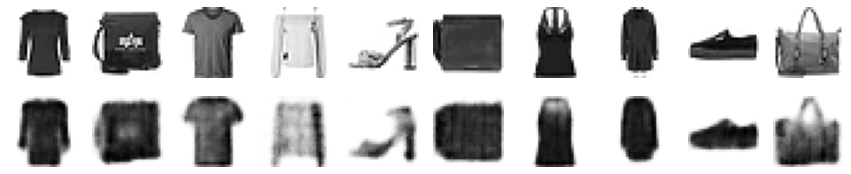

In [ ]:
show_reconstructions(conv_ae)
plt.show()

As you can see, these reconstructions are better than what we obtained with dense layers only. We only trained for 5 epochs; with further training we'd probably do significantly better. 

### Recurrent Autoencoders

For working on sequences or similar problems where RNNs are the better option, we can leverage **Recurrent Autoencoders**. You can find a nice tutorial on building autoencoders from LSTM cells here: https://machinelearningmastery.com/lstm-autoencoders/

### Denoising Autoencoders
So far during training, we use the input image $x$ as both the input and the target and we built our target by minimizing the reconstruction loss compared to $x$. What happens if we slightly corrupt the data by adding some noise to $x$ and making a noisy version called $\tilde{x}$? So the input to the network will be $\tilde{x}$ and the target is still $x$. 

It turns out that if we intentionally add noise to our image like this, we can train our network to automatically _filter_ this noise from the inputs. In other words, it learns features that are robust against small perturbations in the inputs. The network becomes more noise-resiliant. 

<center><img src="https://drive.google.com/uc?id=1fHxtO53MBFsV3n4Sid0ocvRP81dZhF2T" ></center>

Note that in this case, the mapping that the network is trying to find is not from the image to itself but rather from a noisy version to the uncorrupted version. This makes the network more generalizable by reducing the chance of memorization of the input but also can be used as a denoising mechanism. In the picture below, we see the effect of applying a *Denoising Autoencoder (dAE)* to the MNIST dataset.  

IMAGES BEFORE ADDING NOISE:


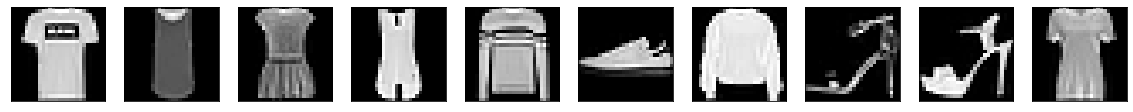

IMAGES AFTER ADDING NOISE:


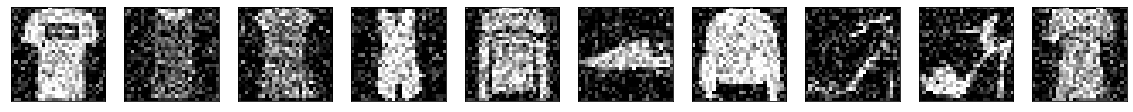

In [ ]:
# There are two ways of doing this. Either we could add Gaussian Noise directly to our inputs, 
# or otherwise we could add a dropout layer immediately after our input. 
# Here, we'll demo the Gaussian Noise approach, so we can see how the 
# autoencoder removes the noise. 

noise_factor = 0.25

X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_valid_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_valid_noisy = np.clip(X_valid_noisy, 0., 1.)


print("IMAGES BEFORE ADDING NOISE:")
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("IMAGES AFTER ADDING NOISE:")
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
# now let's use X_train as our target and X_train_noisy as our input

tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])


conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[rounded_accuracy]
)
history = conv_ae.fit(
    X_train_noisy, 
    X_train, 
    epochs=5,
    validation_data=(X_valid_noisy, X_valid)
)

Epoch 1/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3558 - rounded_accuracy: 0.8859 - val_loss: 0.3123 - val_rounded_accuracy: 0.9137
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3042 - rounded_accuracy: 0.9183 - val_loss: 0.3011 - val_rounded_accuracy: 0.9232
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2959 - rounded_accuracy: 0.9255 - val_loss: 0.2944 - val_rounded_accuracy: 0.9282
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2909 - rounded_accuracy: 0.9298 - val_loss: 0.2905 - val_rounded_accuracy: 0.9318
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2877 - rounded_accuracy: 0.9327 - val_loss: 0.2878 - val_rounded_accuracy: 0.9341


1/1 [==============================] - 0s 121ms/step


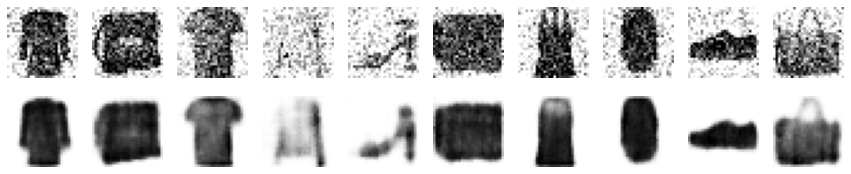

In [ ]:
show_reconstructions(model=conv_ae, images=X_valid_noisy)
plt.show()

You can see that our model was able to remove noise from the images. Again, since we only trained for 5 epochs, we can probably do significantly better with further training and model optimization. 

### Sparse Autoencoders

Sparsity is an another constraint which leads to better feature extraction. We can add a term to our loss function that attempts to reduce the number of 'active' neurons in our coding layer. So for every given sample, it will prefer to learn features that minimize the number of non-zero latent vector elements active for that sample. The model will be encouraged to represent each input as a combination of a small number of activations. As a result, **each neuron** in the coding layer will typically end up representing a useful feature. For instance, if we're encoding faces, one neuron might encode the degree of 'smiling' or 'frowning', another neuron might encode the size of the nose, and so forth. 

Since we then have a 1:1 mapping between activations and relevant learned features, this makes it easier to interpret what features the model is learning. This can also be helpful if we want to 'tune' across these features to generate synthetic images (discussed in the following sections), since we'd only need to change a single latent vector element. 

To achieve this, one approach is to use a sigmoid activation function for the coding layer (constraining the latent vector values to be between 0 and 1), make the coding layer large (e.g. 300 units), and then add L1 regularization to that layer, since we know L1 tries to set non-significant activations to zero.

There is a built-in layer we can use for this, called the `ActivityRegularization` layer. This layer leaves its inputs unchanged, but adds a training loss equal to the sum of the absolute values of its inputs. This encourages the network to produce codings close to zero. Of course, there needs to be some non-zero latent vector elements, in order to reconstruct the image. Thus, the combined effect with the reconstruction loss is to encourage sparse latent vector representations. 






In [ ]:
# training a sparse autoencoder with the ActivityRegularization layer

tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.ActivityRegularization(l1=1e-3), # this adds the sparsity loss term
    keras.layers.MaxPool2D(pool_size=2)

])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])


conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[rounded_accuracy]
)
history = conv_ae.fit(
    X_train, 
    X_train, 
    epochs=5,
    validation_data=(X_valid, X_valid)
)

Epoch 1/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4866 - rounded_accuracy: 0.8496 - val_loss: 0.3779 - val_rounded_accuracy: 0.8939
Epoch 2/5
1875/1875 [==============================] - 8s 5ms/step - loss: 0.3565 - rounded_accuracy: 0.9027 - val_loss: 0.3438 - val_rounded_accuracy: 0.9093
Epoch 3/5
1875/1875 [==============================] - 8s 5ms/step - loss: 0.3331 - rounded_accuracy: 0.9124 - val_loss: 0.3262 - val_rounded_accuracy: 0.9173
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3193 - rounded_accuracy: 0.9192 - val_loss: 0.3153 - val_rounded_accuracy: 0.9224
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3101 - rounded_accuracy: 0.9237 - val_loss: 0.3076 - val_rounded_accuracy: 0.9271


1/1 [==============================] - 0s 127ms/step


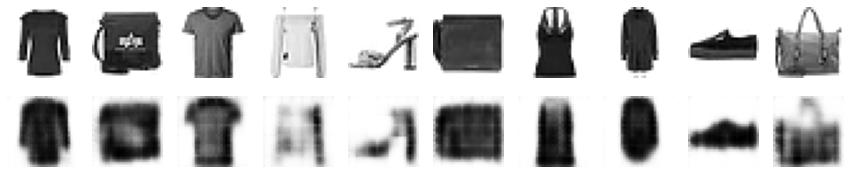

In [ ]:
show_reconstructions(model=conv_ae)
plt.show()

Another technique that works better in practice is to measure the actual sparsity of the coding layer at each training iteration, and penalize the model when the measured sparity differs from a target sparsity. This makes use of the Kullback-Leibler (KL) divergence, and an example of this approach is given on page 585 of the course textbook (Geron, Hands-On ML, 2nd Ed).

### Applications of Autoencoders

Below we elaborate on some of the real-world uses of auto-encoders:

* **Feature Extraction**: this is already self-evident to us. We can train autoencoders on large datasets of unlabelled data (most of the data in the world falls in this category), and then use the features learned by the encoder to bootstrap more specific supervised learning tasks. 

* **Dimensionality Reduction**: techniques such as Principal Component Analysis (PCA) are already widely used in Data Science to better understand trends in data. However, PCA is inherently linear, and does not easily capture complex or non-linear covariances in the data. Autoencoders, on the other hand, do. 

* **Denoising**: as shown, denoising auto-encoders can remove noise from images. This is useful for image or video restorations, or artificially boosting the signal-to-noise ratio of multi-channel datastreams. 

* **Missing Value Imputation**: similar to denoising. If an input data sample is missing a value for one of its features, an auto-encoder can fill it in with a plausible value.

* **Anomaly Detection**: since auto-encoders specialize in reconstructing only the input data distributions they were trained on, inputs that are anomalous (i.e. statistically different from the training distribution) will generally have a much higher reconstruction error. By setting a threshold on this error, we can use an autoencoder to detect anomalies in our data. We could use this for quality control in an assembly line (i.e. identifying defective products), or for 'preventative maintenance'. In the latter, sensors are installed on mission-critical equipment, such as accelerometers that measure equipment vibration, IR cameras that record heat distributions, and so forth. The datastreams are fed through an auto-encoder, and anomalous behaviour shows up as a larger reconstruction loss. This can be used to detect the onset of a malfunction or to monitor wear-and-tear, so that a component can be repaired or replaced in a pro-active way, to avoid sudden, unexpected, catastrophic failure that could cripple a process or assembly line. Another example of where this could be used is for a company that loans vehicles to drivers. By monitoring the vehicle sensor data for anomalies and wear-and-tear, they can make a smarter decision on when it would be more cost-effective to sell that vehicle, rather than keep it in the fleet and maintain it. 



# Part 2: Generative Models

So far we have been talking about **Discriminative** models where the goal is to estimate the conditional probability of a target value $Y$ given the observable value $x = (x_1, ..., x_d)$, symbolically $P(Y|X=x)$. In other words, if $x$ is the data (e.g. a picture) and $y$ is a label (e.g. "Cat") our aim is to learn a *function* that maps $x\rightarrow y$. These models are almost always trained in a *supervised* manner, for tasks such as classification, regression, object detection, and so-forth. 

<center><img src="https://drive.google.com/uc?id=17EOJjsL4ouX2J_L1cOmKNPHsGSo3wINV" ></center>

But what if we wanted to flip this problem around? What if instead, given a target label $Y$, we wanted to synthetically generate a plausible sample $x$?

There is an alternative class of machine learning algorithms that learn the conditional probability of a given observable $x$, given a target value $y$, or $P(X|Y=y)$. This class of learning models are called **Generative** algorithms and the reason behind this, as we shall see later, is that once you have a generative model you can generate new samples from the conditional probability distribution for any given class. For example we can ask the model to generate more "cat" pictures: pictures of cats that are convincing, but don't actually exist. 

We'll learn more about **Generative** algorithms for the rest of this module, and the next one. For an extreme example of what they can achieve, check out this website, which generates believable, synthetic images of people _who have never existed_: https://thispersondoesnotexist.com/



## A 'Classical' Approach: Naive Bayes

Let's take a detour and introduce the concept via a familiar and simple generative model: Naive Bayes. A supervised classification algorithm, Naive Bayes, estimates $P(Y|X=x)$, but it does so by first estimating the class model $P(X|Y=y)$ and prior $P(Y)$ followed by the application of the Bayes rule to find the most probable class label for a given example $x$:

\begin{equation}
P(Y|X=x) = \underset{y}{\arg\max} \frac{P(X|Y=y)P(Y=y)}{P(X)}
\end{equation}

Here: 

 - $P(X|Y=y)$ is the **class model**, or the probability of observing an example given a class label,
 - $P(Y|X=x)$ is the **posterior** probability, or the probability of $Y$ being the true label of the observation $x$,
 - $P(Y)$ is the **prior** probability or the knowledge about the observance of $Y$ before any evidence like $X$ is taken into account. In other words, it signifies which classes are more likely and which are more rare.
 - And finally, $\underset{x}{\arg\max} f(x)$, returns the value for $x$ that maximizes $f(x)$.

The denominator does not affect the prediction in the argmax equation, so we can drop it and put $P(Y|X=x)\approx P(X|Y=y)P(Y)$. In addition, we make the (Naive) *independence assumption* which is at the heart of Naive Bayes. We assume that given $y$, the features $x_1$, ..., $x_d$ are conditionally independent. This turns the previous inequality to:

\begin{equation}
P(Y|X=x)\approx P(X|Y=y)P(Y)\approx P(Y)\prod_{i=1}^{d}P(x_i|Y)
\end{equation}

The independence assumption makes the problem tractable, allowing each $P(x_i|Y)$ to be learned independently. A sensible assumption in order to make the math simpler is to assume that $P(x_i|Y)$ follows a Gaussian distribution (making $P(X|Y)$ a multivariate Gaussian). Then by using the "counting method" we can measure the mean and the variance of the distribution for each class value $Y=y$. Note that at this point we have a model that can *generate* new samples with label $y$ by sampling the multivariate Gaussian $P(X|Y=y)$.

Let's try this on the MNIST dataset. Note that here we do not care much about the discriminative power of Naive Bayes on MNIST but rather want to see if we can generate images of digits by sampling the fitted class model.

Let's download MNIST and fit a Gaussian Naive Bayes model to it:

In [ ]:
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.naive_bayes import GaussianNB
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train.reshape(-1,28 * 28), y_train)

GaussianNB()

As a sanity check, let's draw the mean of each of the 10 classes. Here we use ```gnb.theta_``` which is a $10\times784$ array: $10$ is the number of classes (digits) and $784=28\times28$ is the number of pixels in each image. ```gnb.theta_``` stores the mean value of each pixel in each class:

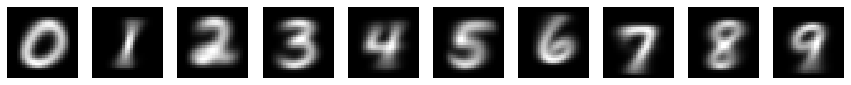

In [ ]:
width=15
fig = plt.figure(figsize=(width, width/2.5))

for i in range(10):
    mean_image = np.array(gnb.theta_[i], dtype='float')
    pixels = mean_image.reshape((28, 28))
    
    sub = fig.add_subplot(1, 10, i + 1)
    sub.imshow(pixels, interpolation='nearest', cmap='gray')
    plt.axis('off')

Now that we have the mean and variance of each class samples, we can use the resulting Gaussian distribution and generate samples from each class by sampling each pixel from the learned Gaussian distribution. Here we generate two sets of samples (`no_of_sets`):

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `sigma_` was deprecated in 1.0 and will be removed in1.2. Use `var_` instead.
  warnings.warn(msg, category=FutureWarning)


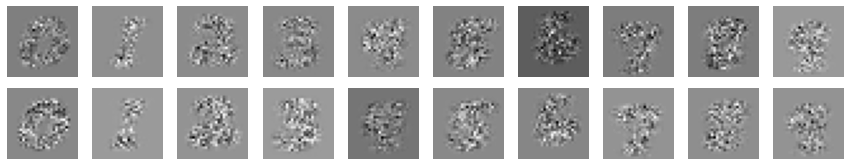

In [ ]:
fig = plt.figure(figsize=(15, 3))
fig.tight_layout()
no_of_sets = 2

for i in range(no_of_sets * 10):
    n = i%10
    mean = np.array(gnb.theta_[n], dtype='float') # mean of all samples of class n (e.g. mean of all '7's)
    std  = np.array(gnb.sigma_[n], dtype='float') # std  of all samples of class n (e.g. std  of all '7's)
    rand_image = np.random.normal(mean, std) # <<<<<<<<<<< Image generation happens here <<<<<<<<<
    pixels = rand_image.reshape((28, 28))
    
    sub = fig.add_subplot(2, 10, i + 1)
    sub.imshow(pixels, cmap='gray')
    plt.axis('off')
plt.subplots_adjust(hspace = 0.001)

<div class="alert alert-block alert-warning">
<b>Note:</b> Here we generated samples conditioned on the class labels, for example we sample from $P(X|Y=7)$ to generate pictures showing number 7, this type of sampling is called "class-conditioned" sampling. However normally in generative models literature, and the rest of the notebook, the density estimation and subsequent sampling is done for $P(X)$.
</div>

So far we have used a generative model to create new samples from the fitted distribution. However, the samples that are generated look more or less like the mean images shown before and they do not look a lot like actual samples from MNIST shown here:

<center><img src="https://drive.google.com/uc?id=1GDXM66_QxdWf5_5C33a8b4wsIXcOiqr7" ></center>


The reason behind this is that Naive Bayes by nature is too simple and fails to model data well, mostly due to the conditional independence assumption we made earlier. In other words, the value of pixels are estimated completely independent of one another and our model is just generating samples by perturbing the mean value of every pixel according to the fitted Gaussian to that pixel. The generative models that we talk about in the rest of this notebook (and later on in *Generative Adversarial Networks* module) have much higher capacity to produce never-before-seen samples that still resemble the training examples.


## Taxonomy of Generative Models
The models that we focus on here are all trained in an *Unsupervised* manner. Unlike supervised learning where we have data and label pairs $(x, y)$, here we just have the data and our goal is to learn some underlying hidden structure of the data. In other words, we would like to fit a probability density function to the given data $P_{data}(x)$ that can estimate the actual density function from which the data was originally generated: $P_{model}(x)$. This is called *density estimation*. After $P_{data}(x)$ is learned, we can then generate images as if we had access to $P_{model}(x)$.

The density estimation can be done in two ways:
 - **Explicit density estimation**: Write down a density function and fit the parameters to the data
 - **Implicit density estimation**: Learn a model that can sample from $P_{model}(x)$ without explicitly defining it.
 
In our toy example for Naive Bayes, after measuring the data probabilities, we explicitly defined the density function to be a Gaussian and fit its parameters (mean and variance) according to the observed samples. So we did an explicit density estimation.

Given this distinction, we can form a taxonomy for generative models:

<figure>
    <center><img src="https://drive.google.com/uc?id=15I_OhtY72GcFIKNAS1aaLOUTTTNfIdw2" ></center>
    <figcaption>
        <center>Goodfellow, I. (2016), Generative Adversarial Networks - NIPS 2016 tutorial. </center><center>Retrieved from https://www.youtube.com/watch?v=HGYYEUSm-0Q</center></figcaption>
</figure>

In this module we will only focus on the <font color='#c92d39'>**Variational Autoencoders (VAE)**</font>. In a later module we will touch on the <font color='#c92d39'>**Fully Visible Belief Networks**</font> and we contrast their density function with that of the VAE's and talk more exclusively about <font color='#c92d39'>**Generative Adversarial Networks (GANs)**</font>.



## Variational Autoencoders

We began our conversation of generative models with the idea of finding a distribution $P_{data}(x)$ that can mimic the true underlying distribution $P_{model}(x)$ from which our training samples were generated. Our goal was then to be able to sample from $P_{data}(x)$ to generate never-before-seen instances. In autoencoders, we saw that the decoder can map values from the latent space to actual images in the original dataset. So prehaps we can generate images by sampling from the latent space and feeding it to the decoder. In fact we can do that by perturbing the encoded values of actual images in our training set and get somewhat different decoded images. But that wouldn't get us too far. Since we don't really know the underlying distribution of the latent space, the images that we generate by small perturbations would be very similar to the images in the training set and we will end up with the same problem as in the Naive Bayes approach. If we perturb the images too much, again because we don't know the correct distribution of the latent space, the results might not look like images at all.

Variational Autoencoders solve this issue in a very elegant way. What if we force the Autoencoder to learn a distribution as the latent variables instead of just single values? In other words, let's constrain the encoder to generate latent vectors that approximate a known distribution, like unit Gaussian. This way generating new images would be easy. All we have to do is to sample from the learned Gaussian and pass the result through the decoder network. This constraint over the latent space is the difference between a Variational Autoencoder and a regular one.

The new end-to-end network looks like this:

<center><img src="https://drive.google.com/uc?id=1ORR7JqHmOQFI5g1eq9XpSol2v4ViyVm8" ></center>


The last layer of the encoder network generates the $\mu$ and $\sigma$ of the Normal distribution, from which a sample is taken that is our new latent vector $z$. The rest is like a normal decoder. Notice that here the network has to solve a trade-off. From one hand, it has to reduce the reconstruction loss (as before), on the other hand, it has to force the latent variables to match the Normal distribution. For the former, we can use a **negative log-likelihood** or **Mean-Squared Error**, which we know from previous modules. For the later, we use  **Kullback-Leibler divergence** (in short KL-divergence) that captures how different two probability distributions are from one another. 

From Wikipedia: *for discrete probability distributions $P$ and $Q$ defined on the same probability space, the Kullback–Leibler divergence from Q to P is defined to be:*
    
\begin{equation}
    \mathcal{D}_\text{KL}(P \| Q) = -\sum_i {P(i)\, \log\left(\frac{Q(i)}{P(i)}\right)}.
\end{equation}

Replace the summation with an integral for continuous distributions.

So overall our loss function for a reconstructed image $x'$ of $x$ would be:

\begin{align}
    L_{reconst} &= \|x - x'\|^2\\
    L_{latent}  &= \mathcal{D}_{KL}(z \| \mathcal{N}(0, 1))\\
    Loss &= L_{reconst} + L_{latent}
\end{align}

<div class="alert alert-block alert-warning">
<b>The math under the hood:</b> Without getting into too many details about the mathematical derivations of VAE's loss function, we present a high-level view of some of the concepts that are important in understanding the code in the demo section.

First, the true loss function of a VAE for a single sample $i$, is given by the following:
$$
l_{i}(\theta, \phi)=-\mathbb{E}_{z \sim q_{\theta}\left(z \mid x_{i}\right)}\left[\log p_{\phi}\left(x_{i} \mid z\right)\right]+\mathcal{D}_{K L}\left(q_{\theta}\left(z \mid x_{i}\right) \| p(z)\right)
$$
<p>
The first term is the reconstruction loss which is given as the expectation over the negative log-likelihood of decoded images. The latent values are sampled from the encoder: $z\sim q_{\theta}(z|x_i)$ and they are reconstructed by the decoder $p_{\phi}(x_i | z)$. The $q_{\theta}(z|x_i)$ is a Gaussian approximation of the true (but intractable) posterior $p_{\theta}(z|x_i)$. The choice of $p_{\phi}(x_i | z)$ depends on the application, and can be Gaussian for real-valued or Bernoulli for binary data. For our MNIST demo example bellow we choose Bernoulli and as a result our reconstruction loss can be a simple *Cross-Entropy* loss.
    
As for the second term, under certain assumptions, we can find an analytical solution for the KL term:


$$
\mathcal{D}_{K L}\left(q_{\theta}\left(z \mid x_{i}\right) \| p(z)\right)=-\frac{1}{2} \sum_{d}\left(1+\log \left(\sigma^{2}\right)-\mu^{2}-\sigma^{2}\right)
$$

This is what we use in our code example below.
</p>

</div>

### VAE: Demo 

Let's get back to the MNIST dataset and try generating new samples using VAE's. 

In [ ]:
# we load and normalize our input data, as usual
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [ ]:
K = keras.backend

# this is a custom layer that will randomsly sample a latent vector
# from a Normal (i.e. Gaussian) distribution, given that distribution's
# mean and log variance
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean


In [ ]:
# metric for evaluating reconstruction performance
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# this number defines the dimensionality of our latent vectors
codings_size = 2

# we define our encoder using the functional API
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)

# this dense layer will learn the 'mean values' for our coding
codings_mean = keras.layers.Dense(codings_size)(z)

# this dense layer will learn the standard deviations (variance) for our coding
codings_log_var = keras.layers.Dense(codings_size)(z)

# this layer will sample a latent vector from a Gaussian distribution
# given the mean and log variance from the previous layers
codings = Sampling()([codings_mean, codings_log_var])

# here we assemble the encoder
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# next we define our decoder, which takes the sampled latent vectors as input
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

# assembling the encoder and decoder into one VAE
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# defining our custom loss function, as per the math described earlier
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)

# compiling and training the model, as usual
variational_ae.compile(loss="binary_crossentropy", optimizer="nadam", metrics=[rounded_accuracy])
history = variational_ae.fit(
    X_train, 
    X_train, 
    epochs=10, 
    batch_size=128,
    validation_data=(X_test, X_test) # used test dataset here for convenience only
)

Epoch 1/10
469/469 [==============================] - 6s 9ms/step - loss: 0.2542 - rounded_accuracy: 0.8767 - val_loss: 0.2315 - val_rounded_accuracy: 0.8875
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2241 - rounded_accuracy: 0.8911 - val_loss: 0.2188 - val_rounded_accuracy: 0.8934
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2167 - rounded_accuracy: 0.8949 - val_loss: 0.2138 - val_rounded_accuracy: 0.8964
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2123 - rounded_accuracy: 0.8979 - val_loss: 0.2141 - val_rounded_accuracy: 0.8974
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2090 - rounded_accuracy: 0.9006 - val_loss: 0.2067 - val_rounded_accuracy: 0.9025
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2063 - rounded_accuracy: 0.9032 - val_loss: 0.2045 - val_rounded_accuracy: 0.9044
Epoch 7/10
469/469 [==============================] 

1/1 [==============================] - 0s 132ms/step


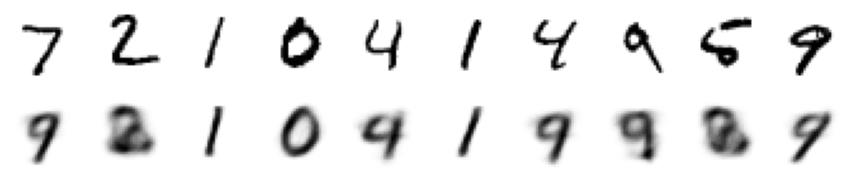

In [ ]:
show_reconstructions(model=variational_ae, images=X_test)
plt.show()

That's good enough for our demo purposes. Now let's generate some digits by feeding the encoder with some noise input over a range of values. Notice how the shape of the digits can change depending on the noise value:

In [ ]:
# a helper function for plotting the images we create
# in a 2D grid
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

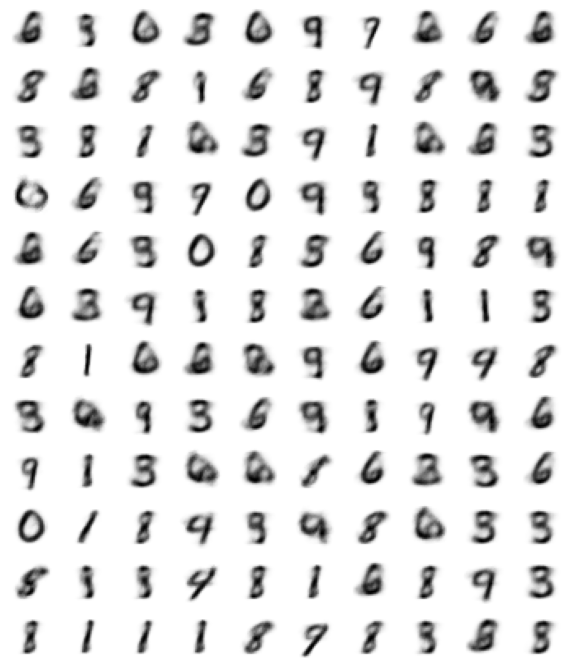

In [ ]:
# we'll sample 120 different latent vectors; we know in advance
# that the latent space of vectors yielding plausible outputs
# follows a Gaussian distribution, so we can pick these vectors
# from that same distribution
codings = tf.random.normal(shape=[120, codings_size])
images = variational_decoder(codings).numpy() # returns output tensors as numpy arrays
plot_multiple_images(images, n_cols=10)

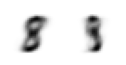

In [ ]:
# here we simply show the images synthesized from
# two specific latent vectors that we've pre-chosen
# (but would still be possible picks from a Gaussian)
codings = tf.constant([[0.27, -.73],[-0.5,-0.5]])

images = variational_decoder(codings).numpy()
plot_multiple_images(images)

In the following image, we have mapped our dataset to our two-dimensional latent space and have applied colour coding based on the sample labels. Each class looks like it could have been generated from a Gaussian distribution, and the distribution of all samples irrespective of class resembles a unit Gaussian distribution. 

<center><img src="https://drive.google.com/uc?id=1wGw7pqf0jJ_12QwyCnVdLTIXhWBYEfMW" ></center>


In the following Figure (ignore the axes units, these are just pixel indices), we've plotted the output images obtained by sweeping the latent vector over a range of values. From left to right, we are sweeping the value of the first coding dimension. From top to bottom, we are sweeping the value of the second. Notice how the digits morph as we adjust each coding value. 

<center><img src="https://drive.google.com/uc?id=1hv-z11KnzTXzN1BFm9IWr2xahAwESd6a" ></center>

This shows how the latent space has captured structural properties that we can take advantage of in order to produce a diverse set of samples. 

When applied to real-world image datasets, such as pictures of faces, this leads to us being able to control some facial features of the faces we generate, or rotate the head, etcetera. In the images below, as we move left-to-right, the latent vector is swept in such a way that the facial expression tunes from smiling to a more passive (non-smiling) expression. 


<p>
<figure>
    <center><img src="https://drive.google.com/uc?id=16fioQgsUBeYjp-10to4oj1tC96MQfpua" ></center>
    <figcaption><center>[<b>Image credit:</b> Higgins, I., Matthey, L., Pal, A., Burgess, C., Glorot, X., Botvinick, M., ... & Lerchner, A. (2016). beta-vae: Learning basic visual concepts with a constrained variational framework.]</center></figcaption>
</figure>
</p>


For further exploration of this concept, here is an online interactive demos that let you tinker with latent space encodings generated by a VAE for MNIST: https://www.siarez.com/projects/variational-autoencoder



VAEs aren't just constrained to image processing tasks. We can also apply them to time-sequence data, for instance. 

In the example shown in this video, two different melodies have been converted into latent vector representations in an RNN-based VAE. Each of these is represented by a mean and standard deviation. Then we create a third distribution that is an interpolation of these original two, and then sample melodies from that distribution. 

The result are new musical melodies that sound like a combination of the original two. 

See the video here:
https://www.youtube.com/watch?v=G5JT16flZwM


As you can image, the possibilities for using VAEs and other generative models for synthesizing new media seem endless. In the following module, we'll explore an even more powerful generative model that represents the state of the art: namely, Generative Adversarial Networks. 

### Exercise: Convolutional VAE

For the MNIST handwritten digit dataset, the VAE we build used dense layers for the encoder and decoder. Of course, convolutional layers would be more appropriate here. 

Given the Fashion MNIST dataset, try to build a convolutional VAE to generate synthetic images of clothing items. 

In [ ]:
(X_train, y_train), (X_test, y_test) =  keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [ ]:
### your response here ...

In [ ]:
### your response here ...

In [ ]:
### your response here ...

In [ ]:
### your response here ...

In [ ]:
### your response here ...

### Solution

In [ ]:
import time

# NOTE: this solution could be a lot more elegant than shown here, 
# but we've gone out of our way to be able to plot several sample
# images after each training batch, to show how the performance
# of the model is improving with training

# Preprocess the data
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) 
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(X_train)
test_images = preprocess_images(X_test)

# batch and shuffle the data
train_size = 60000
batch_size = 32
test_size = 10000

# this is rather unnecessary for this dataset, but let's use
# a Tensorflow Dataset object to hold our data this time
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [ ]:
# Define the encoder and decoder networks with tf.keras.Sequential
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [ ]:
# Define the loss function and the optimizer
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
# Training
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16
batch_size = 32
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

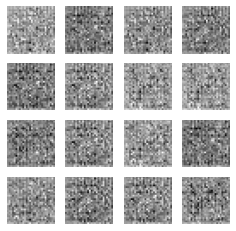

Epoch: 1, Test set ELBO: -223.6962432861328, time elapse for current epoch: 6.446180820465088


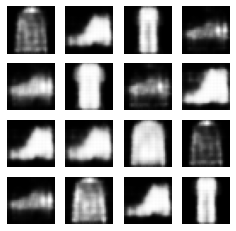

Epoch: 2, Test set ELBO: -212.05767822265625, time elapse for current epoch: 5.2925426959991455


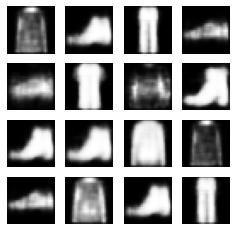

Epoch: 3, Test set ELBO: -206.11061096191406, time elapse for current epoch: 5.2679078578948975


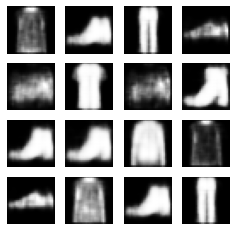

Epoch: 4, Test set ELBO: -203.2854766845703, time elapse for current epoch: 5.2767627239227295


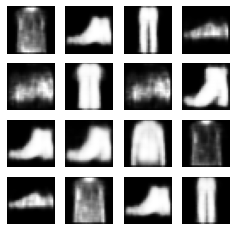

Epoch: 5, Test set ELBO: -199.7368621826172, time elapse for current epoch: 5.561563968658447


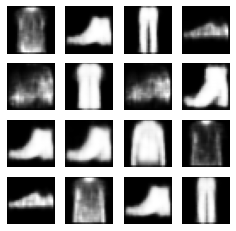

Epoch: 6, Test set ELBO: -198.2015380859375, time elapse for current epoch: 5.252936840057373


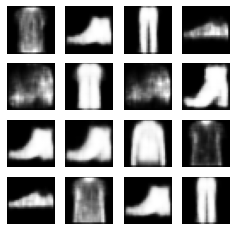

Epoch: 7, Test set ELBO: -196.8623504638672, time elapse for current epoch: 5.257569074630737


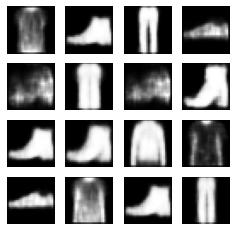

Epoch: 8, Test set ELBO: -196.1024627685547, time elapse for current epoch: 5.2528369426727295


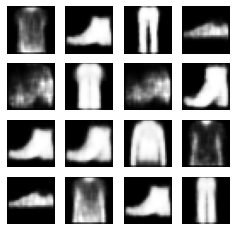

Epoch: 9, Test set ELBO: -195.5931854248047, time elapse for current epoch: 5.293909549713135


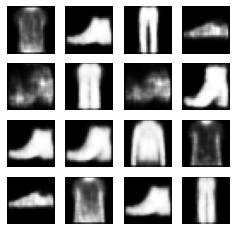

Epoch: 10, Test set ELBO: -194.0927734375, time elapse for current epoch: 5.2206761837005615


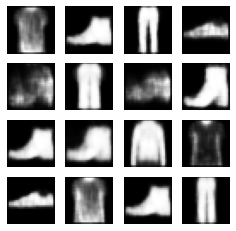

In [ ]:
generate_and_save_images(model, 0, test_sample)

# this will print some sample output images
# after each training epoch
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  # display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

## Resources

1. Generative models
    - https://www.youtube.com/watch?v=5WoItGTWV54&t=1330s
    - http://videolectures.net/deeplearning2017_goodfellow_generative_models/
2. Representation Learning
    - https://arxiv.org/pdf/1206.5538.pdf	
3. Autoencoders
    - https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/autoencoder.ipynb
    - https://www.youtube.com/watch?v=KSYztoOtCo0
    - https://www.youtube.com/watch?v=H3sg6K5iDBM
    - https://blog.keras.io/building-autoencoders-in-keras.html [Good for denoising topic]
4. Variational autoencoders
    - https://hsaghir.github.io/data_science/denoising-vs-variational-autoencoder/
    - https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
    - https://arxiv.org/pdf/1606.05908.pdf
    - http://kvfrans.com/variational-autoencoders-explained/
    - https://wiseodd.github.io/techblog/2017/01/24/vae-pytorch/
5. Further reading: 
    - https://arxiv.org/pdf/1711.05597.pdf
    - https://arxiv.org/pdf/1606.05908.pdf
    - https://www.youtube.com/watch?v=9zKuYvjFFS8


### References 

[Autoencoders and Gans](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb)

[Generating Images with VAES](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.4-generating-images-with-vaes.ipynb)

[PCA to Autoencoders](https://www.youtube.com/watch?v=hbU7nbVDzGE)

[Tutorial on VAEs](https://www.youtube.com/watch?v=uaaqyVS9-rM)

[Tutorial on VAEs](https://arxiv.org/pdf/1606.05908.pdf%20(2))

[Autoencoder Use Cases](https://medium.com/@venkatakrishna.jonnalagadda/sparse-stacked-and-variational-autoencoder-efe5bfe73b64)